In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

CONNECT_MOBILE = True
CONNECT_ROBOT = True
SAVE_DATA = False

MOBILE_IP = "192.168.17.2"
ROBOT_IP = "192.168.17.2"
PANDA_IP = "192.168.17.3"

print("Mobile IP: {}".format(MOBILE_IP))
print("ROBOT  IP: {}".format(ROBOT_IP))
print("PANDA  IP: {}".format(PANDA_IP))

sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/developing/multiobject'))

from concurrent import futures
import logging
import math
import time
import cv2
import numpy as np
import grpc
import RemoteCam_pb2
import RemoteCam_pb2_grpc

MAX_MESSAGE_LENGTH = 10000000
PORT_CAM = 10509

Mobile IP: 192.168.17.2
ROBOT  IP: 192.168.17.2
PANDA  IP: 192.168.17.3


In [2]:
ROBOT_BASE_OFFSET = (-0.28+0.008,0,0.592)
ROBOT_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001
WS_HEIGHT = 1.7
COL_COLOR = (1,1,1,0.2)
    
LOG_FORCE = False

from pkg.controller.combined_robot import *
from pkg.project_config import *

kiro_udp_client.KIRO_UDP_OFFLINE_DEBUG = not CONNECT_MOBILE

mobile_config = RobotConfig(0, RobotType.pmb, ((0,0,0), (0,0,0)), MOBILE_IP)
robot_config = RobotConfig(1, RobotType.panda_arm, 
                           (ROBOT_BASE_OFFSET, ROBOT_BASE_RPY),
                           "{}/{}".format(ROBOT_IP, PANDA_IP), root_on="pmb0_platform")

ROBOT_TYPE = robot_config.type
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config],
                     connection_list=[CONNECT_MOBILE, CONNECT_ROBOT])

connection command:
pmb0: True
panda_arm1: True


### Make scene

In [3]:
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.planning.scene import PlanningScene

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)
gtems = s_builder.add_robot_geometries(
    color=COL_COLOR, display=True, collision=True)

gscene.set_workspace_boundary(
    -1, 4, -2.5, 2.5, -CLEARANCE, WS_HEIGHT, thickness=WALL_THICKNESS)

HOME_POSE_DEFAULT = np.copy(crob.home_pose)
gscene.show_pose(crob.home_pose)
crob.simulator.gscene=gscene

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


### Planning scene

In [4]:
from pkg.geometry.geometry import *
from pkg.utils.code_scraps import *
from pkg.planning.constraint.constraint_subject import *
from pkg.planning.constraint.constraint_actor import *
from exp_config import *

pscene = PlanningScene(gscene, combined_robot=crob)

In [5]:
ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE
BRUSH_NAME = "brush_face"
theta = -np.pi*3/4
viewpoint  = add_panda_cam(gscene, tool_link=TIP_LINK, theta=theta)
brush_face = add_panda_brush(gscene, tool_link=TIP_LINK, theta=theta, brush_name=BRUSH_NAME)

point_brush, rpy_brush = (0,0,-brush_face.dims[2]/2), (0,0,0)
brush_b = pscene.create_binder(BRUSH_NAME, BRUSH_NAME, WayFramer, point=point_brush, rpy=rpy_brush)
gscene.show_pose(HOME_POSE_DEFAULT)

MOBILE_PUSH_NAME = "mpush"
MOBILE_PUSH_HEIGHT = 0.4
MOBILE_PUSH_KEY = 1
MOBILE_SLIDE_KEY = 2
front_dist = 0.03
mpush_g = gscene.create_safe(GEOTYPE.SPHERE, MOBILE_PUSH_NAME, link_name=HOLD_LINK,dims=(0.01,0.01,0.01),
                           center=(front_dist, 0, MOBILE_PUSH_HEIGHT), rpy=(0,np.pi/2,0),
                           fixed=True, collision=False, color=(1,0,0,0.5))
mpush_b = pscene.create_binder(MOBILE_PUSH_NAME, MOBILE_PUSH_NAME, FramedTool, point=(0,0,0), rpy=(0,0,0), key=MOBILE_PUSH_KEY)

floor_b = pscene.create_binder("floor_ws", "floor_ws", PlaceFrame, point=(0,0,WALL_THICKNESS/2), key=MOBILE_SLIDE_KEY)

TOOL_PUSH_NAME = "tpush"
TOOL_PUSH_HEIGHT = 0.03
TOOL_PUSH_KEY = 10
TOOL_SLIDE_KEY = 11
brush_col = gscene.NAME_DICT[BRUSH_NAME+"_col"]
TOOL_DIM = brush_col.dims

center_push, rpy_push = (TOOL_DIM[0]/2+CLEARANCE, 0, 0), (0,np.pi/2,0)    
tpush_g = gscene.create_safe(GEOTYPE.SPHERE, TOOL_PUSH_NAME, link_name=TIP_LINK,dims=(0.01,0.01,0.01),
                           center=center_push, rpy=rpy_push,
                           fixed=True, collision=False, color=(1,0,0,0.5), parent=BRUSH_NAME)
tpush_b = pscene.create_binder(TOOL_PUSH_NAME, TOOL_PUSH_NAME, FramedTool, point=(0,0,0), rpy=(0,0,0), key=TOOL_PUSH_KEY)

### MultiICP Detector

In [6]:
from pkg.detector.multiICP.multiICP import MultiICP, MultiICP_Obj
from pkg.detector.multiICP.config import *
from pkg.detector.camera.realsense import RealSense
from pkg.detector.detector_interface import DetectionLevel

import open3d as o3d
import numpy as np

CONNECT_CAM = False
REMOTE_CAM = True

CARRIER_DIM = (0.4, 0.29, 0.635)
CLOCK_DIM = (0.138, 0.05, 0.078)
TABLE_DIM = (1.6, 0.8, 0.725)

In [7]:
from demo_utils.data_reconstructed_camera import DataRecontructedCamera
dcam = DataRecontructedCamera(crob, viewpoint)
# if not CONNECT_CAM and not REMOTE_CAM:
#     dcam.initialize()

if CONNECT_CAM:
    realsense = RealSense()
    micp = MultiICP(realsense)
    micp.initialize()
else:
    if REMOTE_CAM:
        # use remote camera
        micp = MultiICP(None)
        micp.initialize(remote_cam=REMOTE_CAM)
#         dcam.ready_saving(*micp.get_camera_config())
#         cam_pose = viewpoint.get_tf(VIEW_POSE_EXT)
    else:
        # use manually given camera configs
        micp = MultiICP(None)
        config_list, img_dim = load_pickle(RNB_PLANNING_DIR+"release/multiICP_data/cam_configs.pkl")
        micp.initialize(config_list, img_dim)
#         micp = MultiICP(dcam)
#         micp.initialize()

Camera is not set - skip initialization, use remote camera
request 0 -> response 0
==== Received camera config from remote camera ====


### Shared Detector

In [8]:
from pkg.utils.shared_function import clear_channels_on, sa
clear_channels_on("SharedDetector")

from pkg.detector.multiICP.shared_detector import SharedDetectorGen
sd = SharedDetectorGen(tuple(reversed(micp.dsize))+(3,))()
sd.init()

### Set ICP Config

In [9]:
# Load config file of object information
obj_info_dict = get_obj_info()

In [10]:
micp_suitcase = MultiICP_Obj(obj_info_dict["suitcase"], None,
                        OffsetOnModelCoord("suitcase", R=np.matmul(Rot_axis(1, 2*np.pi/3), Rot_axis(3, np.pi/2)), offset=(0.,0.,0.2)))


micp_clock = MultiICP_Obj(obj_info_dict["clock"], None,
                        OffsetOnModelCoord("clock", R=Rot_axis(1, np.pi/4), offset=(-0.04,-0.03,0.04)))


micp_table = MultiICP_Obj(obj_info_dict["dining table"], None,
                        OffsetOnModelCoord("dining table", R=Rot_axis(1, 3*np.pi/4), offset=(0.,0.35,0.6)))

micp_chair = MultiICP_Obj(obj_info_dict["chair"], None,
                        OffsetOnModelCoord("chair", R=Rot_axis(1, 3*np.pi/4), offset=(0.1, 0.1,0.)))

In [11]:
micp_dict = {"suitcase": micp_suitcase, "clock": micp_clock,
             "dining table": micp_table, "chair": micp_chair}
micp.set_config(micp_dict, sd, crob, viewpoint)

## Table

In [84]:
VIEW_LOC = crob.get_real_robot_pose()[:6]
VIEW_ARM = HOME_POSE_DEFAULT[6:] + np.deg2rad([0,0,0,0,0,45,-45])
VIEW_TABLE = list(VIEW_LOC) + list(VIEW_ARM)
crob.joint_move_make_sure(np.array(VIEW_TABLE), ref_speed=np.pi/8)

In [85]:
TABLE_DIM = (1.6, 0.8, 0.725)
TABLE_NAME = "table"
TABLE_LOC = (3, 0, TABLE_DIM[2]/2)
TABLE_RPY = (0,0,0)

In [86]:
# for dining table
micp.set_ICP_thres(thres_ICP=0.6, thres_front_ICP=0.18)
micp.set_pcd_ratio(ratio=0.5)
micp.set_inlier_ratio(ratio=0.02)
# micp.set_multiobject_num(num = 1)
micp.set_merge_mask(merge=True)
pose_dict = micp.detect(name_mask=["dining table"], visualize=True)

name_mask is ['dining table']
request 0 -> response 0
==== Received color, depth image from remote camera ====
Maximun num of object for detection : 1
===== Detected : dining table, 1 object(s) =====
[NOTICE] You choose merge option for mask. Detected masks would be merged.

'dining table' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.233706e-01, and correspondence_set size of 27990
Access transformation to get result.
Transformation is:
[[ 0.94039859  0.33078888 -0.07892529 -0.61705276]
 [ 0.158782   -0.63231975 -0.75826115  0.63093704]
 [-0.30073039  0.7005358  -0.64715593  2.5518015 ]
 [ 0.          0.          0.          1.        ]]
Total ICP Transformation is:
[[ 0.94039859  0.33078888 -0.07892529 -0.61705276]
 [ 0.158782   -0.63231975 -0.75826115  0.63093704]
 [-0.30073039  0.7005358  -0.64715593  2.5518015 ]
 [ 0.          0.          0.          1.        ]]
Inlier raio:

In [88]:
# add table
center, rpy = pose_refine("dining table", pose_dict["dining table_1"])
table_vis, table_g = add_table(gscene, TABLE_NAME, center, rpy)

In [23]:
# table_g = gscene.create_safe(GEOTYPE.BOX, TABLE_NAME, link_name="base_link", dims=TABLE_DIM,
#                              center=TABLE_LOC, rpy=TABLE_RPY,
#                              fixed=True, collision=True, color=(0.8,0.8,0.8,1))
table_b = pscene.create_binder(TABLE_NAME, TABLE_NAME, PlaceFrame, point=(0,0,TABLE_DIM[2]/2), key=TOOL_SLIDE_KEY)
gscene.add_virtual_guardrail(table_g, HEIGHT=0.01, axis="xy")

### update workspace

In [24]:
Tbt = table_g.get_tf(HOME_POSE_DEFAULT)
Tbm = gscene.get_tf(MOBILE_BASE, HOME_POSE_DEFAULT)
Ttm = np.matmul(np.linalg.inv(Tbt), Tbm)

Ymax = table_g.dims[1]/2
Ymin = Ttm[1,3]-0.9
Xmax = Ttm[0,3]+0.7
Xmin = -table_g.dims[0]/2-0.3
Xtc = np.mean([Xmax, Xmin])
Ytc = np.mean([Ymax, Ymin])
dX = Xmax - Xmin
dY = Ymax - Ymin
Xbc, Ybc, _, _ = np.matmul(Tbt, [Xtc, Ytc, 0, 1])
Xmax, Xmin = Xbc + dX/2, Xbc - dX/2
Ymax, Ymin = Ybc + dY/2, Ybc - dY/2

gscene.set_workspace_boundary(
    Xmin, Xmax, Ymin, Ymax, -CLEARANCE, WS_HEIGHT, thickness=WALL_THICKNESS, 
    RPY=Rot2rpy(Tbt[:3,:3]))

In [25]:
floor_ws = gscene.NAME_DICT["floor_ws"]
gscene.create_safe(GEOTYPE.BOX, "obstacle_corner", link_name="base_link",
                   dims = (0.5,0.5,1), 
                   center=(floor_ws.dims[0]/2-0.3, floor_ws.dims[1]/2-0.3, 0.5), 
                  display=True, collision=True, parent="floor_ws",
                  color=(1,1,0,0.2))

#### [SAVE DATA]

In [19]:
if SAVE_DATA:
    color, depth, Qcur = micp.get_image()
    cam_pose = viewpoint.get_tf(Qcur)
    dcam.ready_saving(*micp.get_camera_config())
    dcam.save_scene(color, depth, cam_pose)

### Chair

In [20]:
panda_arm1 = crob.robot_dict["panda_arm1"]
img_list = []
for theta0 in [-30, 0, 30]:
    VIEW_LOC = crob.get_real_robot_pose()[:6]
#     VIEW_ARM = HOME_POSE_DEFAULT[6:] + np.deg2rad([theta0,-45,0,-70,0,70,-45])
    VIEW_ARM = HOME_POSE_DEFAULT[6:] + np.deg2rad([theta0,-55,0,-65,0,45,-45])
    VIEW_CHAIR = list(VIEW_LOC) + list(VIEW_ARM)
    
    crob.joint_move_make_sure(np.array(VIEW_CHAIR), ref_speed=np.pi/8)
    
    # for chair
    micp.set_ICP_thres(thres_ICP=0.3, thres_front_ICP=0.08)
    micp.set_pcd_ratio(ratio=1)
    micp.set_inlier_ratio(ratio=0.05)
    micp.set_multiobject_num(num = 5)
    micp.set_outlier_removal(nb_points=18, radius=0.05)
    # micp.set_merge_mask(merge=True)
    pose_dict = micp.detect(name_mask=["chair"], visualize=True)
    
    # add or update suitcase
    add_update_object(gscene, crob, "chair", pose_dict, separate_dist=0.28, height = 0)
    
    color, depth = micp.last_input[:2]
    Qcur = crob.get_real_robot_pose()
    
    img_list.append((color, depth))
    
    # save data
    if SAVE_DATA:
        cam_pose = viewpoint.get_tf(Qcur)
        dcam.ready_saving(*micp.get_camera_config())
        dcam.save_scene(color, depth, cam_pose)

name_mask is ['chair']
request 0 -> response 0
==== Received color, depth image from remote camera ====
Maximun num of object for detection : 5
===== Detected : chair, 1 object(s) =====

'chair' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=5.718493e-02, and correspondence_set size of 40406
Access transformation to get result.
Transformation is:
[[ 0.98134152 -0.19153712 -0.01680333 -0.20531098]
 [-0.12571385 -0.57305105 -0.80982004  0.35042464]
 [ 0.14548144  0.79682244 -0.58643765  1.92653218]
 [ 0.          0.          0.          1.        ]]
Total ICP Transformation is:
[[ 0.98134152 -0.19153712 -0.01680333 -0.20531098]
 [-0.12571385 -0.57305105 -0.80982004  0.35042464]
 [ 0.14548144  0.79682244 -0.58643765  1.92653218]
 [ 0.          0.          0.          1.        ]]
Inlier raio: 0.142825300906
initial: 
[[ 0.98 -0.19 -0.02 -0.21]
 [-0.13 -0.57 -0.81  0.35]
 [ 0.15  0.8  -0

Inlier raio: 0.0267598842816

'chair' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.725326e-02, and correspondence_set size of 10667
Access transformation to get result.
Transformation is:
[[ 0.89829703 -0.43824638 -0.03166305  0.18298016]
 [-0.32440383 -0.61289187 -0.72050377 -0.45116063]
 [ 0.29635216  0.65749801 -0.69272775  3.01398422]
 [ 0.          0.          0.          1.        ]]
Total ICP Transformation is:
[[ 0.89829703 -0.43824638 -0.03166305  0.18298016]
 [-0.32440383 -0.61289187 -0.72050377 -0.45116063]
 [ 0.29635216  0.65749801 -0.69272775  3.01398422]
 [ 0.          0.          0.          1.        ]]
Inlier raio: 0.185282522996
initial: 
[[ 0.9  -0.44 -0.03  0.18]
 [-0.32 -0.61 -0.72 -0.45]
 [ 0.3   0.66 -0.69  3.01]
 [ 0.    0.    0.    1.  ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=9.674940e-01, inlier_rmse=2.552527e-02, and cor

In [21]:
# for i in range(10):
#     try:
#         gscene.remove(gscene.NAME_DICT["chair_{}".format(i)])
#     except:
#         pass

In [22]:
gcol_names = sorted([gname for gname in gscene.NAME_DICT.keys() 
                 if "chair" in gname and "col" in gname])
chair_names = []

for gcol_name in gcol_names:
    chair_col_g = gscene.NAME_DICT[gcol_name]
    chair_g = gscene.NAME_DICT[chair_col_g.parent]
    chair_dim = chair_col_g.dims
    chair_name = chair_g.name
    chair_names.append(chair_name)
    push_point_list = []
    for i in range(4):
        R = Rot_axis_series([3, 2], [np.pi/2*i, np.pi/2])
        point = np.round(np.multiply(chair_dim, -R[:,2])/2, 4)
        point[2] = MOBILE_PUSH_HEIGHT
        ap_name = "side{}".format(i)
        push_point_list.append(FramePoint(ap_name, chair_g, point=point, rpy=Rot2rpy(R), key=MOBILE_PUSH_KEY))

    slide_point = SlidePoint("bottom_p", chair_g, point=(0,0,-CLEARANCE), rpy=(0,0,0), 
                                               binded_on=floor_b, dist_push_min=0.1, dist_push_max=1.0, key=MOBILE_SLIDE_KEY)

    chair_s = pscene.create_subject(oname=chair_name, gname=chair_name, _type=PushObject, 
                                  push_point_list=push_point_list, slide_point=slide_point)

## Add  ref waypoint

In [23]:
table_body = gscene.NAME_DICT[TABLE_NAME]

WP_NAME = "wp_0"
WP_DIM = (0.1,0.1,0.01)
WP_LOC = (0, -0.2, table_body.dims[2]/2)
WP_RPY = (0,0,np.pi/2)

wp_g = gscene.create_safe(GEOTYPE.BOX, WP_NAME, link_name="base_link", 
                          dims=WP_DIM,
                          center=(WP_LOC[0], WP_LOC[1], WP_LOC[2]), rpy=WP_RPY,
                          fixed=True, collision=True, color=(0.0,0.0,0.8,1), parent=TABLE_NAME)

waypoint_s = pscene.create_subject(oname="waypoints", gname=TABLE_NAME, _type=WaypointTask,
                                 action_points_dict={
                                     wp_g.name: WayFrame(
                                         wp_g.name, wp_g, [0, 0, wp_g.dims[2] / 2], [0, 0, 0])
                                 })

### prepare planner

In [99]:
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
gcheck = GraspChecker(pscene)
rcheck = ReachChecker(pscene)

from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene, enable_dual=False)
mplan.update_gscene()
mplan.incremental_constraint_motion = True

from pkg.planning.incremental_search import *
# joint motion is not allowed when pusing object with holder
idc_push = np.where([stype == PushObject for stype in pscene.subject_type_list])[0]
inc = IncrementalSearch(pscene, gcheck, rcheck, 
                        explicit_rule= lambda pscene, node, leaf: not any([node[idx]==leaf[idx] and "push" in node[idx] for idx in idc_push]))
inc.prepare()
inc.set_motion_planner(mplan)
inc.prepare()

cresv = CollisionResolver(inc, gcheck)
rresv = ReachResolver(inc, rcheck, mplan, floor=floor_b.geometry)
mresv = MotionResolver(inc, mplan)
inc.resolver_stack = [cresv, rresv, mresv]

from pkg.ui.ui_broker import *
# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(inc, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

[WARN] reach data is not ready for pmb. Ignoring this robot...
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
generate table - Geometry
generate table - Handle
generate table - Binder
generate table - Object


### Plan

In [25]:
gscene.show_pose(VIEW_TABLE)
chain_list = \
    [BindingChain(chair_name, "bottom_p", "floor_ws", "floor_ws") for chair_name in chair_names] \
    + [BindingChain("waypoints", None, None, None)]
# chain_list = \
#     [BindingChain(bag_name, "bottom_p", "floor_ws", "floor_ws") for chair_name in chair_names] \
#     + [BindingChain(clock_name, "bottom_p", "table", "table") for clock_name in clock_names] \
#     + [BindingChain("waypoints", None, None, None)]
initial_state = pscene.initialize_state(VIEW_TABLE, chain_list=chain_list)
gscene.update_markers_all()
print(pscene.subject_name_list)
print(initial_state.node)

   Use a production WSGI server instead.
 * Debug mode: off
['chair_0', 'chair_1', 'chair_2', 'chair_3', 'waypoints']
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)


In [26]:
crob.joint_move_make_sure(initial_state.Q)

## DEV planner

In [27]:
from nonholonomic_planner import *

nhp = NonHolonomicPlanner(mplan, MOBILE_NAME)
def custom_planner(group_name, tool_link, goal_pose, target_link, from_Q,
                   timeout=1, **kwargs):
    if group_name == MOBILE_NAME:
        Tbm = np.matmul(gscene.get_tf(target_link, from_Q), 
                        T_xyzquat((goal_pose[:3], goal_pose[3:])))
        to_Q = Tbm[:2, 3].tolist()+[Rot2axis(Tbm[:3,:3], 3)]
        traj = nhp.search(from_Q, to_Q, timeout=timeout, update_gscene=False)
        return traj, traj is not None
    else:
        return mplan.planner.plan_py(group_name, tool_link, goal_pose, target_link, from_Q,
                       timeout=1, **kwargs)
    
def custom_planner_joint(group_name, goal_state, Q_init, timeout=1, **kwargs):
    if group_name == MOBILE_NAME:
        traj = nhp.search(Q_init, goal_state[:3], timeout=timeout, update_gscene=False)
        return traj, traj is not None
    else:
        return mplan.planner.plan_joint_motion_py(group_name, goal_state, Q_init, timeout=1, **kwargs)
    
mplan.custom_planner = custom_planner
mplan.custom_planner_joint = custom_planner_joint

In [28]:
crob.home_pose = initial_state.Q
crob.home_dict = list2dict(crob.home_pose, crob.joint_names)

In [29]:
from_state = initial_state.copy(pscene)
goal_nodes = [initial_state.node[:-1]+(1,)]

inc.search(from_state, goal_nodes, max_solution_count=1,
           verbose=False, display=False, dt_vis=0.001, 
           timeout=1.0, timeout_loop=200, 
           multiprocess=True, add_homing=False)

Use 10/20 agents
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
======================= terminated 9: required answers acquired  (52.7/200.0) ===============================
======================= terminated 8: Stop called from other agent  (52.8/200.0) ===============================
======================= terminated 7: Stop called from other agent  (52.9/200.0) ===============================
======================= terminated 6: Stop called from other agent  (53.0/200.0) ===============================
======================= terminated 2: Stop called from other agent  (53.0/200.0) ===============================
======================= terminated 0: Stop called from other agent  (53.0/200.0) ===============================
======================= terminated 4: Stop called from other agent  (53.0/200.0) ===============================
======================= terminated 5: Stop called from other agent  (53.1/200.0) ========================

### Get snode schedule

In [51]:
snode_schedule = inc.get_best_schedule(at_home=False)
snode_schedule += inc.add_return_motion(snode_schedule[-1], initial_state=initial_state)

### play schedule

In [55]:
snode_schedule_move = []
for snode in snode_schedule:
    if snode.state.node[-1] != 0:
        break
    snode_schedule_move.append(snode)

In [56]:
pscene.set_object_state(initial_state)
gscene.show_pose(initial_state.Q)

In [57]:
len(snode_schedule_move)

10

In [59]:
inc.play_schedule(snode_schedule_move, period=0.002)
# inc.play_schedule(snode_schedule[2:], period=0.01)
pscene.set_object_state(snode_schedule_move[-1].state)

('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'mpush', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'mpush', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'mpush', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'mpush', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'mpush', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'mpush', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)


In [60]:
vel_lims, acc_lims, dt_step = 0.5, 0.5, 0.02
snode_schedule_safe = [snode_schedule_move[0].copy(pscene)]
for snode, snode_pre in zip(snode_schedule_move[1:], snode_schedule_move[:-1]):
    snames, _ = pscene.get_changing_subjects(snode.state, snode_pre.state)
    if len(snames) > 1:
        raise(RuntimeError("More than 1 subject change - {}".format(snames)))
    if len(snames) == 1:
        subject = pscene.subject_dict[snames[0]]
    else:
        subject = None
    if isinstance(subject, PushObject):
        snode_cp = snode.copy(pscene)
        snode_schedule_safe.append(snode_cp)
    else:
        snode_cp = snode.copy(pscene)
        traj_simp = simplify_traj(snode.traj)
        snode_cp.set_traj(
            calc_safe_trajectory(
                dt_step, traj_simp, vel_lims=vel_lims, acc_lims=acc_lims)[1])
        snode_schedule_safe.append(snode_cp)

In [61]:
inc.execute_schedule(snode_schedule_safe, one_by_one=True)

No motion for connected robot - playing motion in RVIZ
No motion for connected robot - playing motion in RVIZ
[WARN] ROBOT MOTION TIMEOUT


True

## Clock

In [62]:
for i in range(5):
    try:
        gscene.remove(gscene.NAME_DICT["clock_{}".format(i)])
    except:
        pass

In [63]:

# VIEW_REF_POSE = [3.5,0,0,0,0,0]+list(crob.home_pose[6:]+[0,0,0,0,0,np.pi/4,-np.pi/4])
# gscene.show_pose(VIEW_REF_POSE)

## get initial pose toward table

In [64]:
Qcur = crob.get_real_robot_pose()
Tbt = table_body.get_tf(Qcur)
Tbr = gscene.get_tf(ROBOT_BASE, Qcur)
Trt = np.matmul(np.linalg.inv(Tbr), Tbt)
Qcur[6] = np.arctan2(Trt[1,3], Trt[0,3])
gscene.show_pose(Qcur)

## get look motions

In [107]:
Qview_init = crob.get_real_robot_pose()
Qview_init[6:] = Qview_init[6:] + [0,0,0,0,0,np.deg2rad(-20),0]

In [108]:
gscene.show_pose(Qview_init)

In [109]:
viewpoint = gscene.NAME_DICT["viewpoint"]
traj_list = get_scan_motions(mplan, viewpoint, table_g, Qview_init)

In [112]:
Qview_list = []
for traj in traj_list:
    gscene.show_pose(traj[-1])
    Qview_list.append(np.copy(traj[-1]))
    time.sleep(1)

In [113]:
crob.joint_move_make_sure(Qview_init)

In [72]:
for Qview in Qview_list:
    break

In [139]:
Qview = Qview_list[0]

In [140]:
t, traj = calc_safe_trajectory(0.02, [crob.get_real_robot_pose(), Qview], 0.5, 0.5)
gscene.show_motion(traj)

In [141]:
crob.joint_move_make_sure(np.array(Qview), ref_speed = np.pi/10)

In [142]:
# for clock
micp.set_ICP_thres(thres_ICP=0.09, thres_front_ICP=0.03)
micp.set_outlier_removal(nb_points=20, radius=0.03)
micp.set_inlier_ratio(0.05)
micp.set_multiobject_num(num=3)
pose_dict = micp.detect(name_mask=["clock"], visualize=True)

name_mask is ['clock']
request 0 -> response 0
==== Received color, depth image from remote camera ====
Maximun num of object for detection : 3
clock not detected


In [143]:
# add or update clock
add_update_object(gscene, crob, "clock", pose_dict, separate_dist=0.2, height = TABLE_DIM[2]+CLOCK_DIM[1]/2)

Total 3 clock in the scene


In [145]:
gscene.show_pose(crob.get_real_robot_pose())

request 0 -> response 0
==== Received color, depth image from remote camera ====


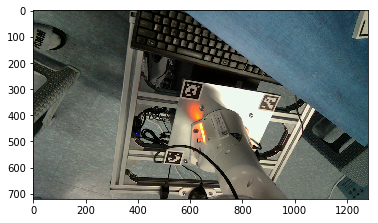

In [146]:
plt.imshow(micp.get_image()[0])

In [113]:
# CLOCK_NAME = "clock_{}"
# CLOCK_DIM = (0.14,0.05,0.076)
# clock_center = np.add(wp_g.center[:2]+(0,), (0,0.1,TABLE_DIM[2]+CLOCK_DIM[2]/2+CLEARANCE))

In [114]:
# for i_c in range(CLOCK_COUNT):
#     CLOCK_NAME_I = CLOCK_NAME.format(i_c)
#     clock_g = gscene.create_safe(GEOTYPE.BOX, CLOCK_NAME_I, link_name="base_link",dims=CLOCK_DIM,
#                                center=(clock_center[0], clock_center[1]-i_c*0.4, clock_center[2]), rpy=(0,0,0),
#                                fixed=False, collision=True, color=(0.8,0.5,0.3,1))

#     push_point_list = []
#     for i in range(4):
#         R = Rot_axis_series([3, 2], [np.pi/2*i, np.pi/2])
#         point = np.round(np.multiply(CLOCK_DIM, -R[:,2])/2, 4)
#         point[2] = -CLOCK_DIM[2]/2 + TOOL_PUSH_HEIGHT
#         ap_name = "side{}".format(i)
#         push_point_list.append(FramePoint(ap_name, clock_g, point=point, rpy=Rot2rpy(R), key=TOOL_PUSH_KEY))

#     dir_push = [0,0,1]
#     slide_point = SlidePoint("bottom_p", clock_g, point=(0,0,-CLOCK_DIM[2]/2-CLEARANCE), rpy=(0,0,0), 
#                              binded_on=table_b, dist_push_min=0.1, dist_push_max=0.3, dir_push=dir_push, key=TOOL_SLIDE_KEY)

#     clock_s = pscene.create_subject(oname=CLOCK_NAME_I, gname=CLOCK_NAME_I, _type=PushObject, 
#                                   push_point_list=push_point_list, slide_point=slide_point)

#### [SAVE DATA]

In [ ]:
# if SAVE_DATA:
#     color, depth, Qcur = micp.get_image()
#     cam_pose = viewpoint.get_tf(Qcur)
#     dcam.ready_saving(*micp.get_camera_config())
#     dcam.save_scene(color, depth, cam_pose)

## Marker set

In [469]:
from pkg.detector.aruco.marker_config import *

aruco_map = get_aruco_map()

cameraMatrix, distCoeffs, _ = micp.get_camera_config()
color_img, _, Q_cur = micp.get_image()
color_img = color_img.astype(np.uint8)
obj_dict, corner_dict = aruco_map.get_object_pose_dict(color_img, cameraMatrix, distCoeffs)
img_out = aruco_map.draw_objects(color_img, obj_dict, corner_dict, cameraMatrix, distCoeffs)
T_cp = obj_dict["panda1"]
T_pc = viewpoint.get_tf(crob.get_real_robot_pose(), from_link=ROBOT_BASE)
T_pp = np.matmul(T_pc, T_cp)
np.round(T_pp, 3)

request 0 -> response 0
==== Received color, depth image from remote camera ====


array([[ 0.999,  0.04 , -0.01 , -0.   ],
       [-0.04 ,  0.999,  0.009, -0.003],
       [ 0.01 , -0.009,  1.   ,  0.007],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

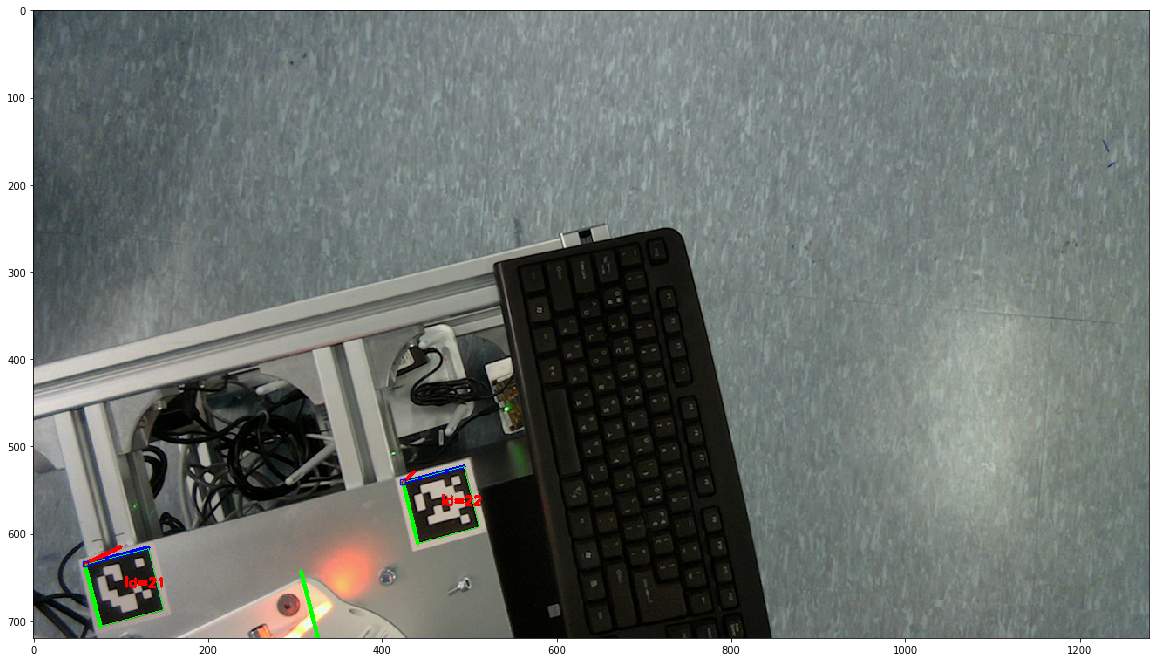

In [470]:
plt.figure(figsize=(20, 15))
plt.imshow(img_out)

### temporary - robot base detection for accuracy check

In [471]:
# res_dict = {}
res_dict[Qnow[-1]] = T_pp

In [472]:
qxyz = np.array([(q, T_pp[0,3], T_pp[1,3], T_pp[2,3])  for q, T_pp in sorted(res_dict.items())])

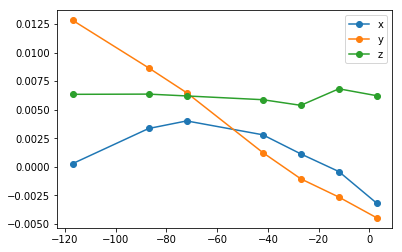

In [473]:
plt.plot(np.rad2deg(qxyz[:,0]), qxyz[:,1], '-o')
plt.plot(np.rad2deg(qxyz[:,0]), qxyz[:,2], '-o')
plt.plot(np.rad2deg(qxyz[:,0]), qxyz[:,3], '-o')
plt.legend("xyz")

In [392]:
# Qnow = panda_arm1.get_qcur()

In [464]:
Qnow[-1] = np.deg2rad(-27+15)

In [465]:
gscene.show_pose([0]*6+list(Qnow))

In [466]:
T = viewpoint.get_tf(np.array([0]*6+list(Qnow)))

In [467]:
crob.joint_move_make_sure(np.array([0]*6+list(Qnow)))

### temporary - robot base detection for accuracy check

## Waypoints

In [198]:
pscene.remove_subject("waypoints")
gscene.remove(gscene.NAME_DICT["wp_0"])

In [199]:
WP_NAME = "wp_{}"
WP_DIM = (0.1,0.1,0.01)
Tbc = viewpoint.get_tf(crob.get_real_robot_pose())

wp_g_list = []
for i_t in range(3,4):    
    Tco = obj_dict["target{}".format(i_t)]
    Tbo = np.matmul(Tbc, Tco)
    wp_g = gscene.create_safe(GEOTYPE.BOX, WP_NAME.format(i_t), link_name="base_link", dims=WP_DIM,
                              center=Tbo[:3,3], rpy=Rot2rpy(Tbo[:3,:3]),
                              fixed=True, collision=True, color=(0.0,0.0,0.8,1))
    wp_g_list.append(wp_g)
waypoint_s = pscene.create_subject(oname="waypoints", gname=TABLE_NAME, _type=WaypointTask,
                                 action_points_dict={
                                     wp_g.name: WayFrame(
                                         wp_g.name, wp_g, [0, 0, wp_g.dims[2] / 2], [0, 0, 0])
                                     for wp_g in wp_g_list
                                 })

#### [SAVE DATA]

In [ ]:
if SAVE_DATA:
    color, depth, Qcur = micp.get_image()
    cam_pose = viewpoint.get_tf(Qcur)
    dcam.ready_saving(*micp.get_camera_config())
    dcam.save_scene(color, depth, cam_pose)

In [62]:
crob.reset_connection(False, True)

connection command:
pmb0: False
panda_arm1: True


### Drawing node graph

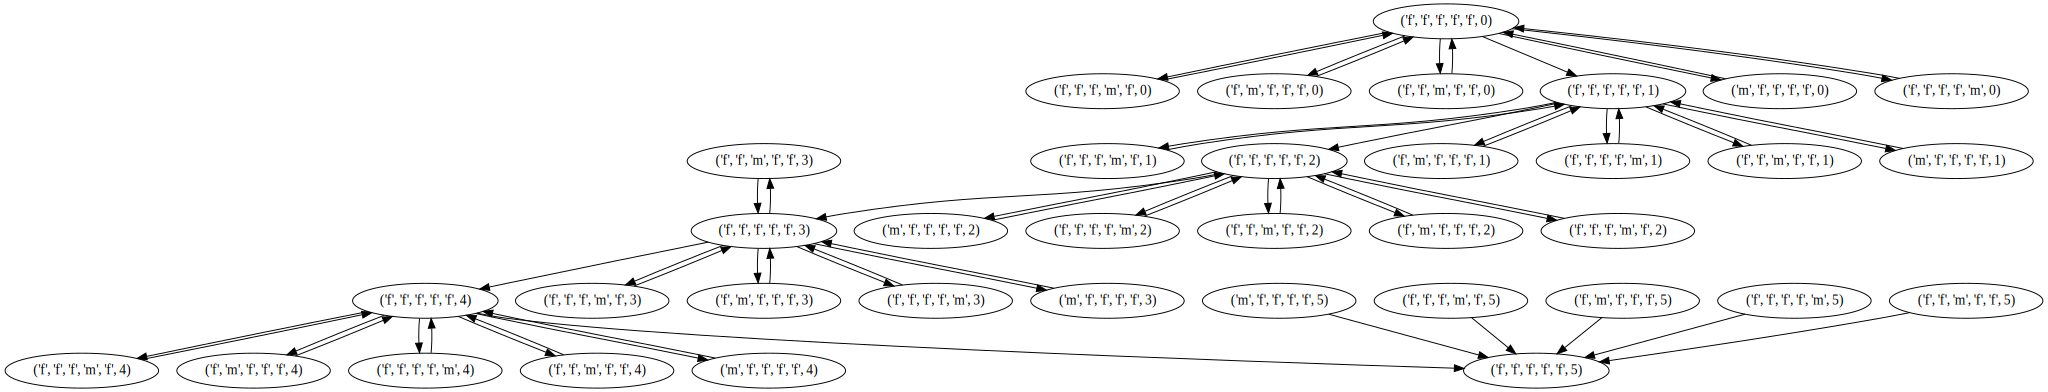

In [20]:
from pkg.utils.graph_visualize import *

vg = VisualGraph()

def simplify_node(node):
    return tuple([ntem[0] if isinstance(ntem, str) else ntem for ntem in node])

for node, leafs in inc.node_dict.items():
    vg.add_node(simplify_node(node), [simplify_node(leaf) for leaf in leafs])
    
gv = vg.draw()
# gv.save()
gv

## TODO 02.06

### Detector
* 마커, 시계 현장 인식 테스트 v
* point cloud visualization 에서 0 포인트 에러 발생
* 90도 돌아간 인식

### HW
* 바퀴 높이 맞춤 90x40x6mm L shape w. profile hole x 2 뽑기
* 대형 장애물 마련하기
  - 가방? 앞뒤만 밀 수 있게 전제, 가이드레일 및 앞 범퍼 만들기
  - 의자? 방에서 미니 의자 가져와서 테스트, 다른의자 구해보기

### Planner
* 전2륜 전제로 모바일 경로 트래킹 알고리즘 보강 (늦어짐)
  - 현장 실제어주기 확인 ~15 ms
* 테이블 커버하는 view 자세/모션들 만들기

## TODO 01.31
### data
* 인식 결과 샘플 저장

### Detector
* 첫 인식에서 캐리어 4개만 인식됨 (다시 인식하면 5개 나옴)
* 마커 인식 추가

### Planner
* 바퀴가 자꾸 멈춤 - 강제로 정지되면 다이나믹셀이 셧다운 됨 - 펌웨어 수정 필요
* 플래닝 성능 개선

### Anydesk 자동 연결 설정 (소형 모니터 연결?)



## Testing detection 

In [19]:
dist_ref = 3.52

In [21]:
T_bt = table_vis.get_tf(crob.home_pose)

In [22]:
T_bc = viewpoint.get_tf(crob.get_real_robot_pose())

In [23]:
T_ct = np.matmul(np.linalg.inv(T_bc), T_bt)

In [24]:
np.linalg.norm(T_ct[:3,3])

3.601818945289152

In [25]:
color_img = micp.last_input[0]

In [41]:
Rot2rpy(Rot_axis(1, -np.pi/2))

array([-1.57079633, -0.        ,  0.        ])

In [50]:
 def get_aruco_map_table():
    dictionary = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
    #     params = aruco.DetectorParameters_create()
    aruco_map = ArucoMap(dictionary=dictionary, _dict={
        'table1':MarkerSet('table1', dlevel=DetectionLevel.ENVIRONMENT, gtype=GEOTYPE.BOX, dims=(0.4,0.3,0.01),
                          color=(0.9,0.9,0.9,0.2),
                          _list=[
                              ObjectMarker('table1', 231, 0.15, [0, 0., 0.0], (0, -0., 0.)),
#                               ObjectMarker('table', 231, 0.15, [0.7, -0.4, 0.0], (0,0,0)),
#                               ObjectMarker('table', 233, 0.15, [0.7+0.075, -0.4, 0.075], (-1.57079633, -0.,  0.))
                          ]),
        'table2':MarkerSet('table2', dlevel=DetectionLevel.ENVIRONMENT, gtype=GEOTYPE.BOX, dims=(0.4,0.3,0.01),
                          color=(0.9,0.9,0.9,0.2),
                          _list=[
                              ObjectMarker('table2', 232, 0.15, [0.0, 0.0, 0.0], (0,0,0)),
#                               ObjectMarker('table', 233, 0.15, [0.7+0.075, -0.4, 0.075], (-1.57079633, -0.,  0.))
                          ]),
        'table3':MarkerSet('table3', dlevel=DetectionLevel.ENVIRONMENT, gtype=GEOTYPE.BOX, dims=(0.4,0.3,0.01),
                          color=(0.9,0.9,0.9,0.2),
                          _list=[
                              ObjectMarker('table3', 233, 0.15, [0.0, 0.0, 0.0], (0,0,0)),
#                               ObjectMarker('table', 233, 0.15, [0.7+0.075, -0.4, 0.075], (-1.57079633, -0.,  0.))
                          ])})
    return aruco_map

In [55]:
from pkg.detector.aruco.marker_config import *

aruco_map = get_aruco_map_table()

cameraMatrix, distCoeffs, _ = micp.get_camera_config()
color_img, _, Q_cur = micp.get_image()

color_img = color_img.astype(np.uint8)
obj_dict, corner_dict = aruco_map.get_object_pose_dict(color_img, cameraMatrix, distCoeffs)
img_out = aruco_map.draw_objects(color_img, obj_dict, corner_dict, cameraMatrix, distCoeffs)

request 0 -> response 0
==== Received color, depth image from remote camera ====


In [58]:
# Tcm1 = obj_dict["table1"]
Tcm2 = obj_dict["table2"]
Tcm3 = obj_dict["table3"]

In [60]:
T_bc = viewpoint.get_tf(crob.get_real_robot_pose())

In [61]:
# Tbm1 = np.matmul(T_bc, Tcm1)
Tbm2 = np.matmul(T_bc, Tcm2)
Tbm3 = np.matmul(T_bc, Tcm3)

In [62]:
gscene.add_highlight_axis("hl", "tbm2", T=Tbm2)
gscene.add_highlight_axis("hl", "tbm3", T=Tbm3)

In [66]:
pmb0 = crob.robot_dict["pmb0"]

In [68]:
Tbm0 = gscene.get_tf(MOBILE_BASE, crob.get_real_robot_pose())

In [131]:
pmb0.joint_move_make_sure([-1.0,0,0,0,0,0])

In [112]:
np.round(crob.get_real_robot_pose()[:6], 3)

array([ 0., -0., -0.,  0.,  0.,  0.])

In [93]:
gscene.show_pose(crob.get_real_robot_pose())

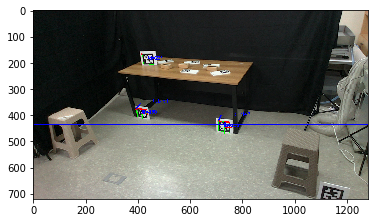

In [63]:
plt.imshow(img_out[:,:,[2,1,0]])

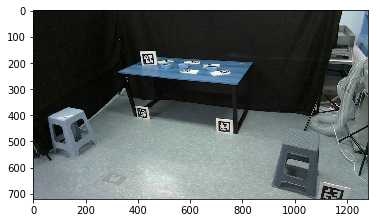

In [18]:
plt.imshow(micp.last_input[0])